In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from PIL import Image 
from collections import defaultdict
import seaborn as sns

2025-06-11 18:17:45.109303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749665865.309372      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749665865.363958      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
image_size = 224
batch_size = 32
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
epochs = 25

## **Import Dataset**

In [3]:
base_dir = "../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(base_dir,"train")
test_dir = os.path.join(base_dir,"valid")

### **Identify Plant Diseases**

The PlantVillage dataset [1] by Hughes et al. that we're going to use for this project consists of about 87,000 healthy and unhealthy leaf images divided into 38 categories by species and disease. Here we provide a subset of our experiments on working with this data. We also end up transfer learning from MobileNet and use the weights from pre-training on ImageNet.

<!-- * ![PlantVillage Dataset Samples](https://i.imgur.com/Zcxdrlc.png)
Figure 1. PlantVillage Dataset Samples -->

#### **Classes**

There are 38 classes availaible in the dataset

- `Apple___Apple_scab` 
- `Apple___Black_rot` 
- `Apple___Cedar_apple_rust` 
- `Apple___healthy` 
- `Blueberry___healthy` 
- `Cherry_(including_sour)___Powdery_mildew` 
- `Cherry_(including_sour)___healthy` 
- `Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot` 
- `Corn_(maize)___Common_rust_` 
- `Corn_(maize)___Northern_Leaf_Blight` 
- `Corn_(maize)___healthy', 'Grape___Black_rot` 
- `Grape___Leaf_blight_(Isariopsis_Leaf_Spot)` 
- `Grape___healthy` 
- `Orange___Haunglongbing_(Citrus_greening)` 
- `Peach___Bacterial_spot` 
- `Peach___healthy` 
- `Pepper,_bell___Bacterial_spot` 
- `Pepper,_bell___healthy` 
- `Potato___Early_blight` 
- `Potato___Late_blight` 
- `Potato___healthy` 
- `Raspberry___healthy` 
- `Soybean___healthy` 
- `Squash___Powdery_mildew` 
- `Strawberry___Leaf_scorch` 
- `Strawberry___healthy` 
- `Tomato___Bacterial_spot` 
- `Tomato___Late_blight` 
- `Tomato___Leaf_Mold` 
- `Tomato___Septoria_leaf_spot` 
- `Tomato___Spider_mites Two-spotted_spider_mite` 
- `Tomato___Target_Spot` 
- `Tomato___Tomato_Yellow_Leaf_Curl_Virus` 
- `Tomato___Tomato_mosaic_virus` 
- `Tomato___healthy`

## References

[1] Hughes, David P., and Marcel Salathe. “An Open Access Repository of Images on Plant Health to Enable the Development of Mobile Disease Diagnostics.” ArXiv:1511.08060 [Cs], Apr. 2016. arXiv.org, http://arxiv.org/abs/1511.08060.

[2] Howard, Andrew G., et al. “MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications.” ArXiv:1704.04861 [Cs], Apr. 2017. arXiv.org, http://arxiv.org/abs/1704.04861.


## **Data Preprocessing**

We make the following augmentations to the images:

- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- `rescale` is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
- `shear_range` is for randomly applying shearing transformations
- `zoom_range` is for randomly zooming inside pictures
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

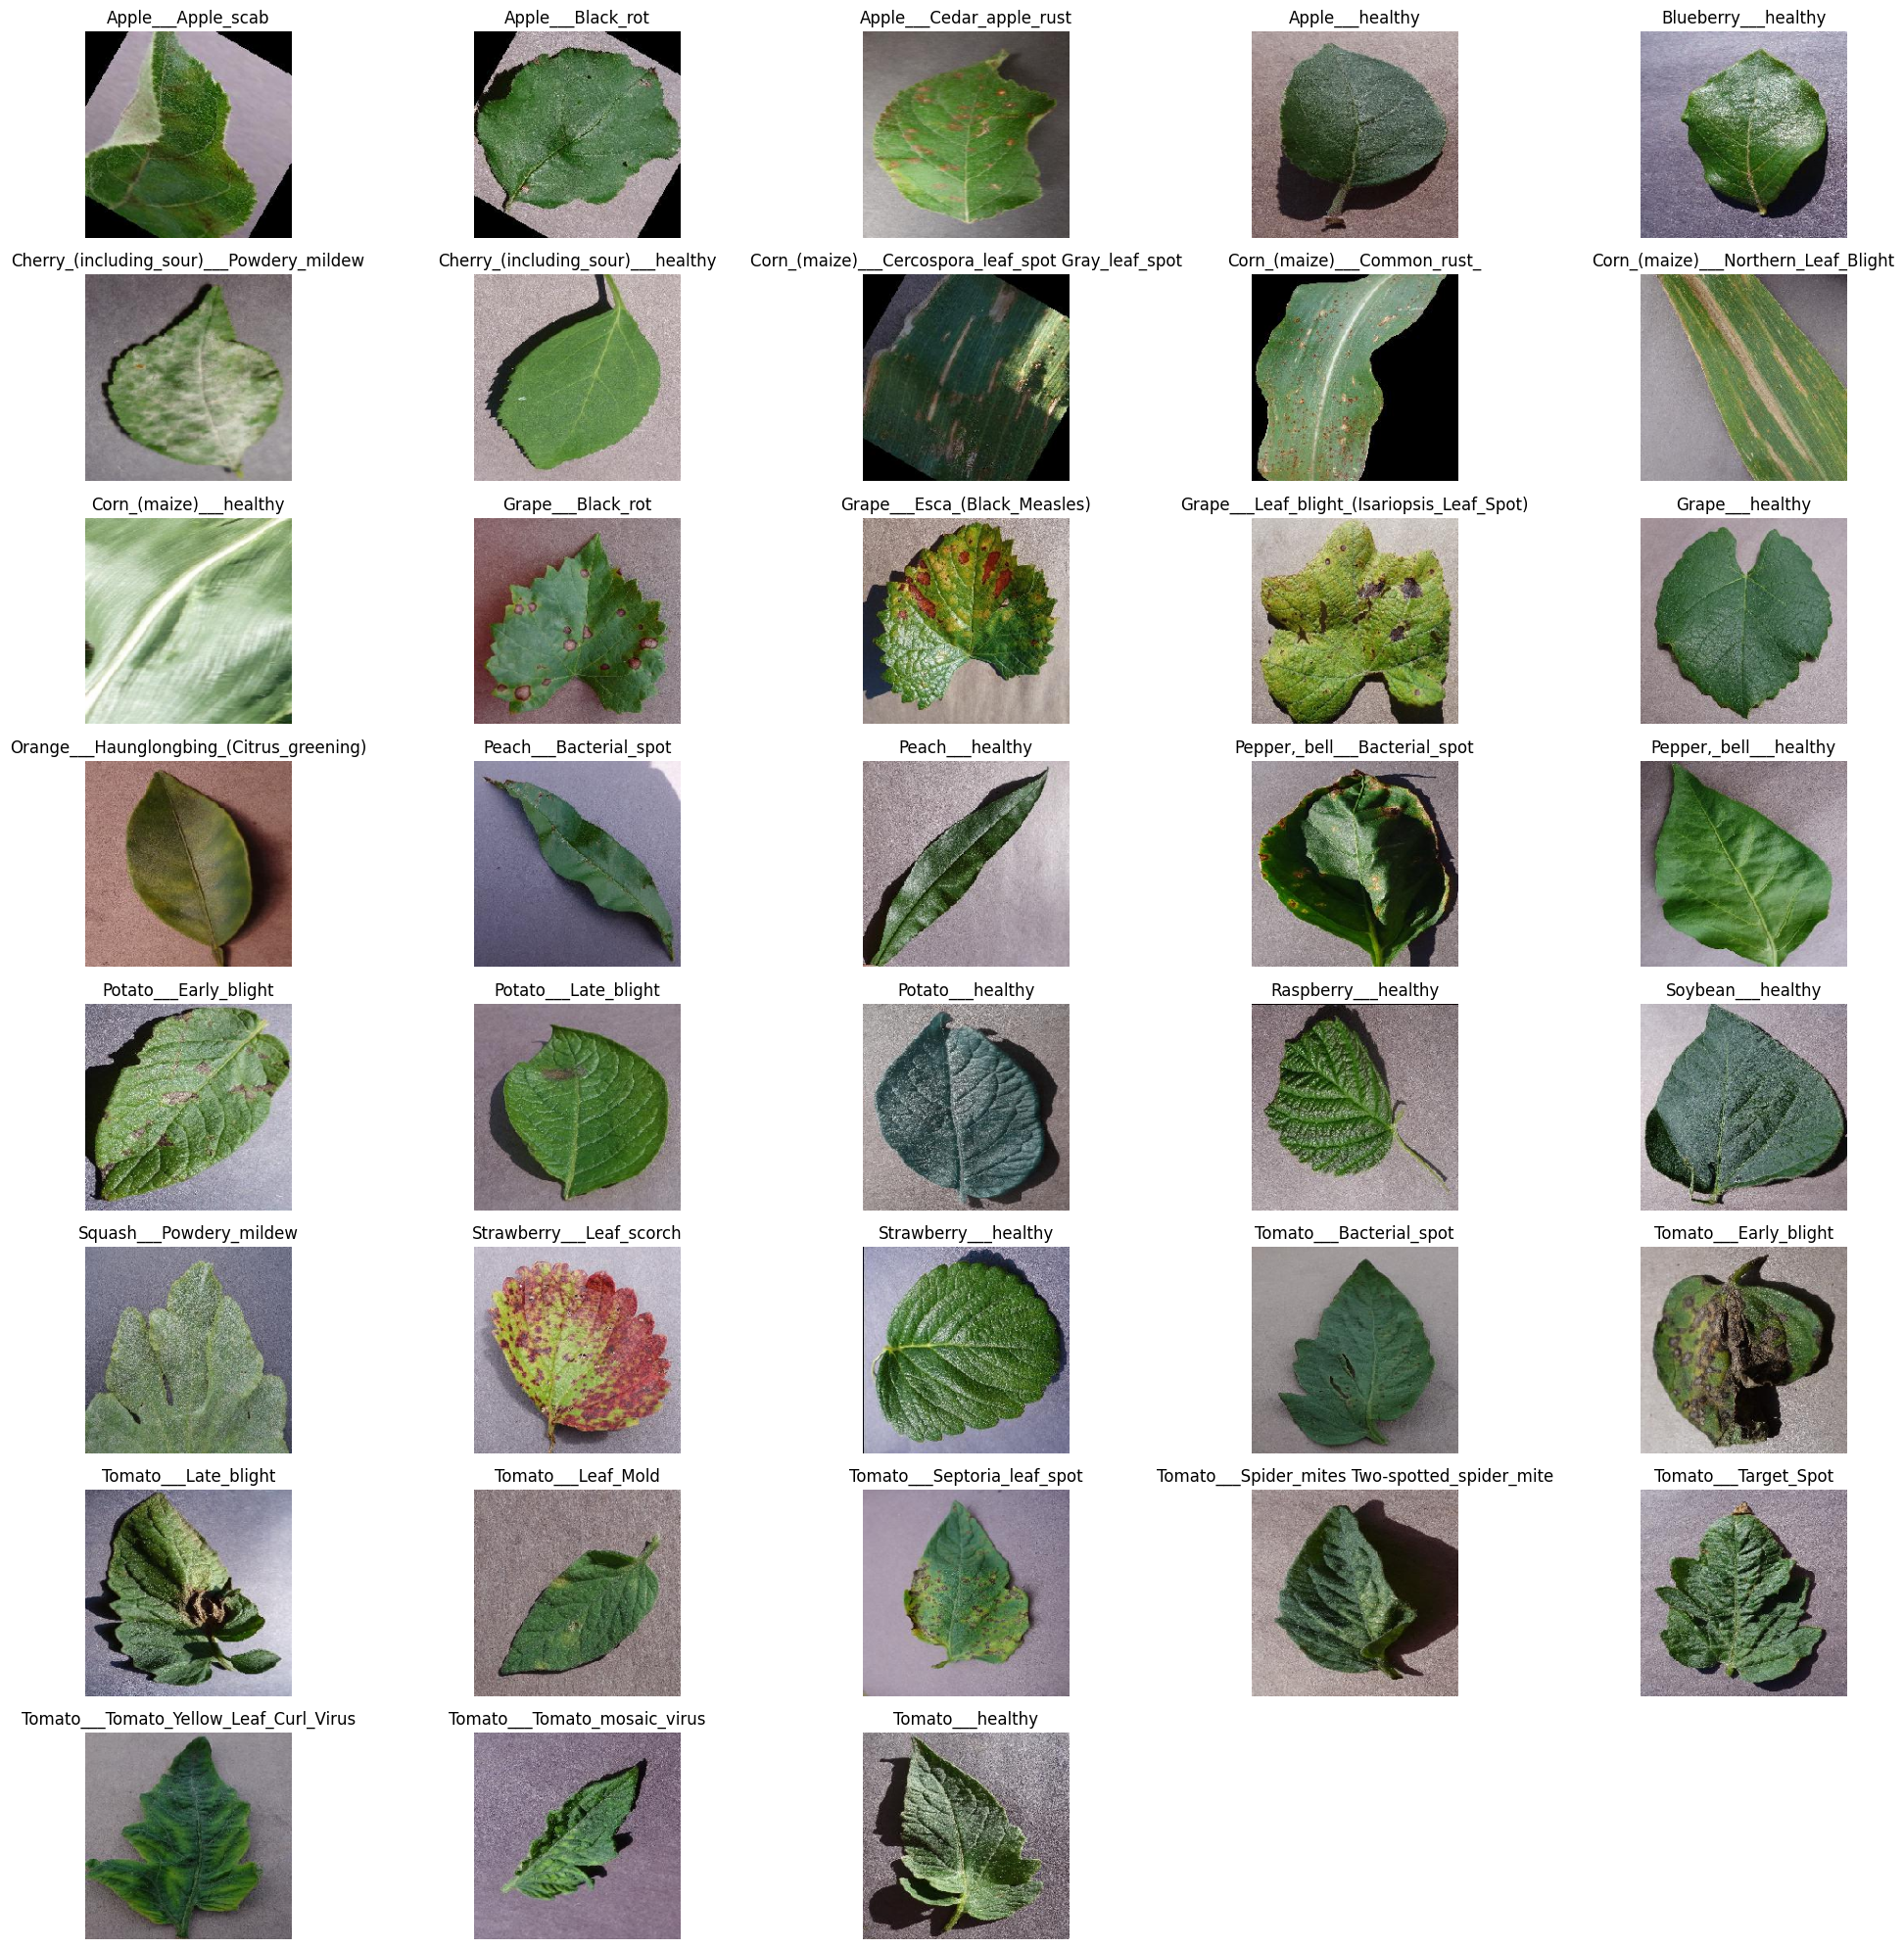

In [4]:
def show_images_from_each_class(data_dir, num_classes, images_per_class=1):
    """
    Displays a grid of images, showing one sample from each class.
    It reads directly from the directories to guarantee that each class is shown.

    Args:
        data_dir: The path to the directory containing the class subdirectories.
        num_classes: The number of classes in the dataset.
        images_per_class: How many images to display from each class.
    """
    plt.figure(figsize=(20, 20))
    cols = 5
    rows = (num_classes + cols - 1) // cols

    class_names = sorted(os.listdir(data_dir))  
    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        image_files = os.listdir(class_dir)
        if len(image_files) > 0:
            img_path = os.path.join(class_dir, image_files[0])
            img = image.load_img(img_path, target_size=(224, 224))  
            img_array = image.img_to_array(img) / 255.0 #normalize

            plt.subplot(rows, cols, class_index + 1)
            plt.imshow(img_array)
            plt.title(class_name, fontsize=12)
            plt.axis('off')
        else:
            plt.subplot(rows, cols, class_index + 1)
            plt.text(0.5, 0.5, f"No images in {class_name}", ha='center', va='center', color='red')
            plt.axis('off')

    plt.tight_layout()
    plt.savefig('each_classes.png',dpi=300)
    plt.show()

show_images_from_each_class(train_dir, num_classes=38, images_per_class=1)


In [5]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,shear_range = 0.2,zoom_range = 0.2,width_shift_range = 0.2,
                                                             height_shift_range = 0.2,fill_mode="nearest")

In [6]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

In [7]:
train_data = train_datagen.flow_from_directory(train_dir,target_size = (image_size, image_size),
                                               batch_size = batch_size,class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,target_size = (image_size, image_size),
                                             batch_size = batch_size,class_mode = "categorical")

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


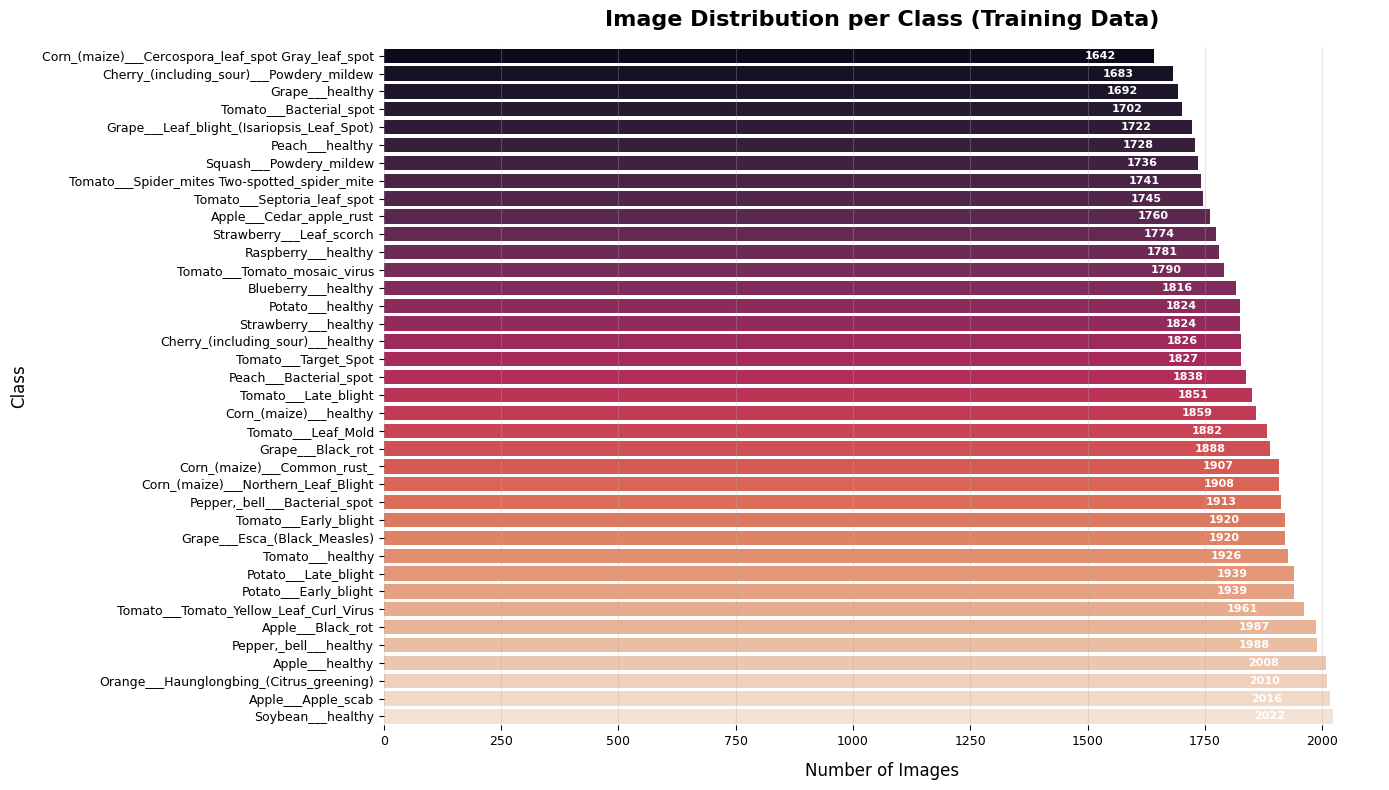

In [8]:
class_counts = defaultdict(int)
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1])
class_names = [item[0] for item in sorted_classes]
counts = [item[1] for item in sorted_classes]
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=counts, y=class_names, palette="rocket", orient='h')
plt.title('Image Distribution per Class (Training Data)', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Number of Images', fontsize=12, labelpad=10)
plt.ylabel('Class', fontsize=12, labelpad=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
for i, (name, count) in enumerate(sorted_classes):
    ax.text(count - 0.05*count, i, f'{count}', va='center', ha='right', color='white', fontsize=8, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('image_dist_classes.png',dpi=300)
plt.show()

In [12]:
import random

sample_image_paths = []
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) 
                 if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            sample_image_paths.extend(images)

# Randomly select sample images (or use first 1)
if sample_image_paths:
    sample_image_paths = random.sample(sample_image_paths, min(1, len(sample_image_paths)))
else:
    print("⚠️ No images found in training directory!")
    sample_image_paths = None

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

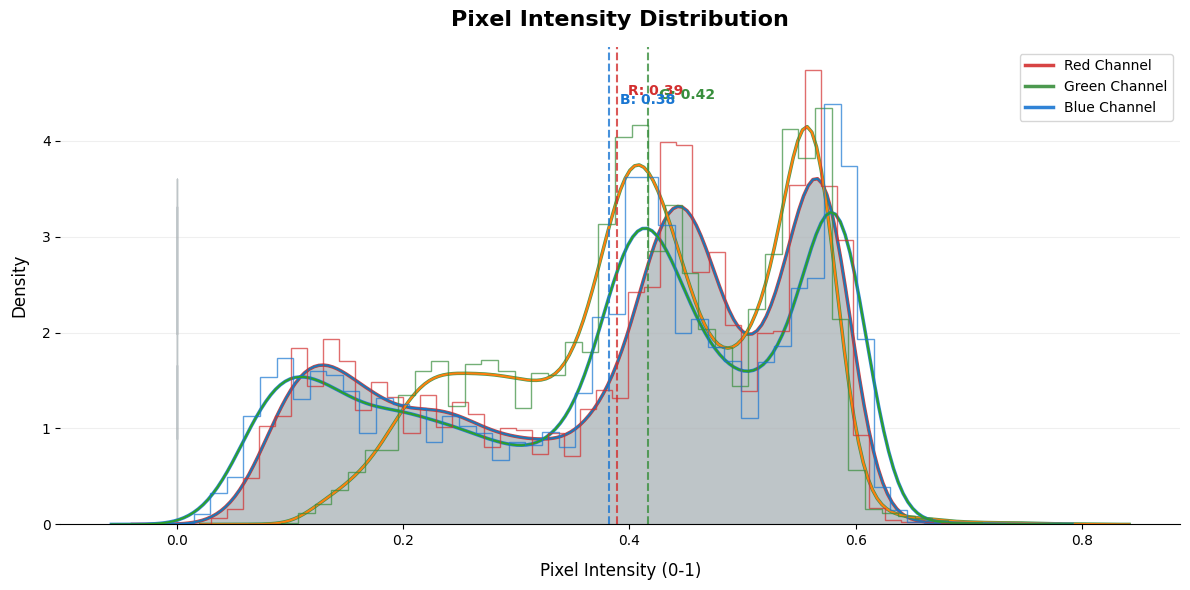

In [18]:
if sample_image_paths:
    sample_img_pil = Image.open(sample_image_paths[0]).resize((image_size, image_size))
    sample_img_np = np.array(sample_img_pil) / 255.0  # Normalize to 0-1
    
    plt.figure(figsize=(12, 6))
    colors = ['#D32F2F', '#388E3C', '#1976D2']  # Rich Red, Forest Green, Deep Blue
    channel_names = ['Red', 'Green', 'Blue']
    
    for i, color in enumerate(colors):
        channel_data = sample_img_np[:, :, i].flatten()
        sns.kdeplot(channel_data, color=color, linewidth=2.5, alpha=0.9, label=f'{channel_names[i]} Channel')
        plt.fill_betweenx(*sns.kdeplot(channel_data).get_lines()[0].get_data()[::-1],color=color, alpha=0.15)
        
    plt.hist(sample_img_np[:,:,0].flatten(), bins=50, color=colors[0], histtype='step', alpha=0.7, density=True)
    plt.hist(sample_img_np[:,:,1].flatten(), bins=50, color=colors[1], histtype='step', alpha=0.7, density=True)
    plt.hist(sample_img_np[:,:,2].flatten(), bins=50, color=colors[2], histtype='step', alpha=0.7, density=True)
    plt.title(f'Pixel Intensity Distribution', fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Pixel Intensity (0-1)', fontsize=12, labelpad=10)
    plt.ylabel('Density', fontsize=12, labelpad=10)
    plt.grid(axis='y', alpha=0.2)
    for i, color in enumerate(colors):
        mean_val = sample_img_np[:, :, i].mean()
        plt.axvline(mean_val, color=color, linestyle='--', alpha=0.8)
        plt.text(mean_val + 0.01, plt.ylim()[1]*0.9 - i*0.05, f'{channel_names[i][0]}: {mean_val:.2f}', color=color, fontsize=10, fontweight='bold')
    
    plt.legend(fontsize=10, frameon=True, facecolor='white')
    sns.despine(left=True)
    plt.tight_layout()
    plt.savefig('pixel_intensity_sample.png',dpi=300)
    plt.show()

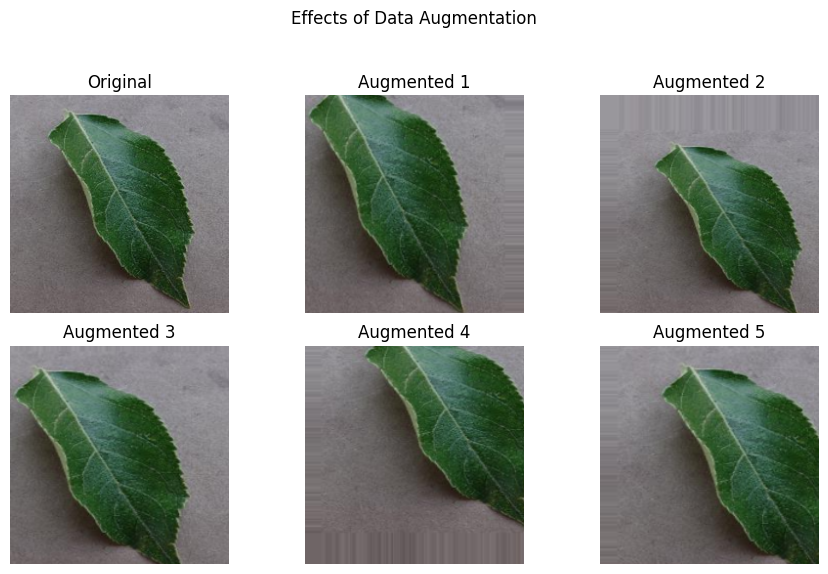

In [23]:
#Augmentation Effects
if sample_image_paths:
    example_img_path = sample_image_paths[0] 
    original_img = Image.open(example_img_path).resize((image_size, image_size))
    original_img_np = np.array(original_img) 
    img_batch = np.expand_dims(original_img_np, axis=0)
    plt.figure(figsize=(9, 6))
    plt.subplot(2, 3, 1)
    plt.imshow(original_img)
    plt.title('Original')
    plt.axis('off')

    i = 2
    for batch in train_datagen.flow(img_batch, batch_size=1):
        if i > 6:
            break
        plt.subplot(2, 3, i)
        plt.imshow(batch[0]) 
        plt.title(f'Augmented {i-1}')
        plt.axis('off')
        i += 1
    plt.suptitle("Effects of Data Augmentation")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('augementation_in_effect.png', dpi=300)
    plt.show()

## **Create a classes**

In [8]:
categories = list(train_data.class_indices.keys())
list(train_data.class_indices.keys())

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [9]:
import json
with open('class_indices.json','w') as f:
  json.dump(train_data.class_indices, f)

from IPython.display import FileLink
FileLink(r'class_indices.json')

/kaggle/working/class_indices.json

## **Training**

Base model

We are going to use the prebuilt MobileNet model. MobileNet is one of those models. It’s special because it’s lightweight—designed to work fast even on devices like phones, not just big computers.

When using this pre-trained MobileNet model for your leaf disease identification task (with training=False), the base model is "frozen." This means it doesn’t learn anything new from your leaf images. Instead, it takes the general feature-extraction skills it already has from ImageNet and applies them to your leaf images. So, to answer your question directly:

In [10]:
from tensorflow.keras import applications
base_model = applications.MobileNet(weights = "imagenet", include_top=False, input_shape = input_shape)
base_model.trainable = False

#We now create a small upstream model on top of the MobileNet using the functional API
inputs = keras.Input(shape = input_shape)
#we then pass the input data through a pretrained base model whihc processes th image
x = base_model(inputs, training = False)
#GAP reduces the spatial dimenstion of the each feature map - 2D to Single value
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#drop out layer that randomly disables 20% of the neruons
x = tf.keras.layers.Dropout(0.2)(x)
#adds a fully connected (dense) layer with a number of neurons equal to the number of categories using the softmax activation
x = tf.keras.layers.Dense(len(categories), activation="softmax")(x)
#the complete neural network model by linking the input layer (inputs) to the output layer (x)
model = keras.Model(inputs = inputs, outputs = x, name="LeafDisease_MobileNet")

2025-04-27 09:29:25.690839: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


The custom layers we add on top of the MobileNet base model. These layers (like GlobalAveragePooling2D, Dropout, or Dense layers) are the "last bit" to build on our own, and they’re designed specifically for our leaf diseases.

While the frozen base model provides general features (e.g., "this leaf has a certain texture or shape"), the custom layers take those general features and learn how to interpret them for your specific problem. For example:

The base model might detect a pattern or edge on a leaf.
The custom layers learn that this particular pattern means "healthy leaf" or "diseased leaf" based on your leaf dataset.

### **Optimization**

> In our multiple experiments we found out Adam optimizer to work really well with it's default learning rate, $\beta_1$, $\beta_2$ and $\epsilon$ values

In [11]:
#adjust the model's weights during training with Adam
#Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer = optimizer,loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=[keras.metrics.CategoricalAccuracy(), 'accuracy'])

#### **How the Training Works Overall**

> This line of code performs the following steps:

- **Trains the Model:** It uses train_data to teach the neural network over multiple passes (epochs), processing 150 batches of training - data in each pass.
- **Evaluates Progress:** After each epoch, it checks the model’s performance on 100 batches of test_data (used as validation data) to see how well it’s learning and generalizing.
- **Tracks Results:** It saves the training and validation metrics in the history variable for later analysis.

In [12]:
history = model.fit(train_data, #training data
                    validation_data=test_data,#validation dataset for acucuracy
                    epochs=10, #number of times models goes through the data
                    steps_per_epoch=150,
                    validation_steps=100)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.2623 - categorical_accuracy: 0.2623 - loss: 2.9646 - val_accuracy: 0.7866 - val_categorical_accuracy: 0.7866 - val_loss: 0.8336
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.7639 - categorical_accuracy: 0.7639 - loss: 0.8726 - val_accuracy: 0.8597 - val_categorical_accuracy: 0.8597 - val_loss: 0.5139
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.8246 - categorical_accuracy: 0.8246 - loss: 0.6217 - val_accuracy: 0.8978 - val_categorical_accuracy: 0.8978 - val_loss: 0.3752
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8586 - categorical_accuracy: 0.8586 - loss: 0.4742 - val_accuracy: 0.9100 - val_categorical_accuracy: 0.9100 - val_loss: 0.3185
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8891 - categorical_accuracy: 0.8891 - loss: 0.3867 - val_accuracy: 0.9000 - val_categorical_accuracy: 0.9000 - val_loss: 0.3113
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


150/150 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.8936 - categorical_accuracy: 0.8936 - loss: 0.3583 - val_accuracy: 0.9175 - val_categorical_accuracy: 0.9175 - val_loss: 0.2583
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.9097 - categorical_accuracy: 0.9097 - loss: 0.3055 - val_accuracy: 0.9141 - val_categorical_accuracy: 0.9141 - val_loss: 0.2692
Epoch 9/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9026 - categorical_accuracy: 0.9026 - loss: 0.3227 - val_accuracy: 0.9309 - val_categorical_accuracy: 0.9309 - val_loss: 0.2208
Epoch 10/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.9156 - categorical_accuracy: 0.9156 - loss: 0.2759 - val_accuracy: 0.9312 - val_categorical_accuracy: 0.9312 - val_loss: 0.2136


### **Training Evaluation**

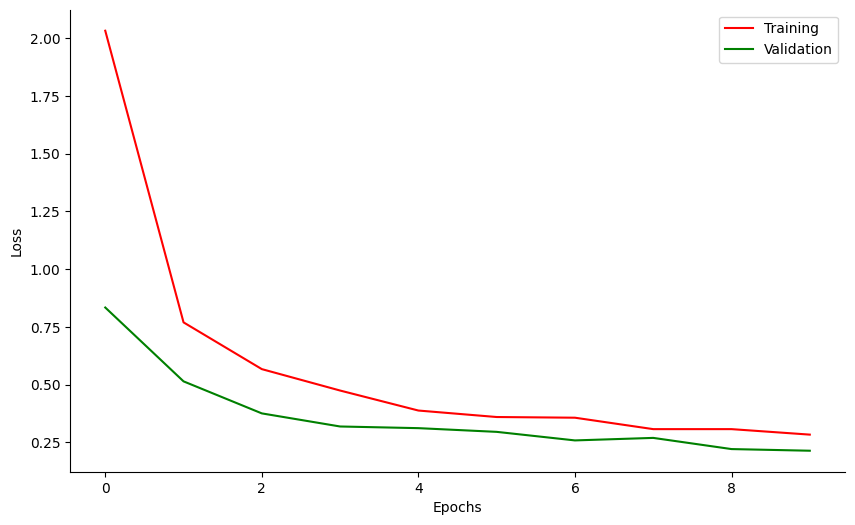

In [13]:
import seaborn as sns
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="green",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
sns.despine()
plt.legend()

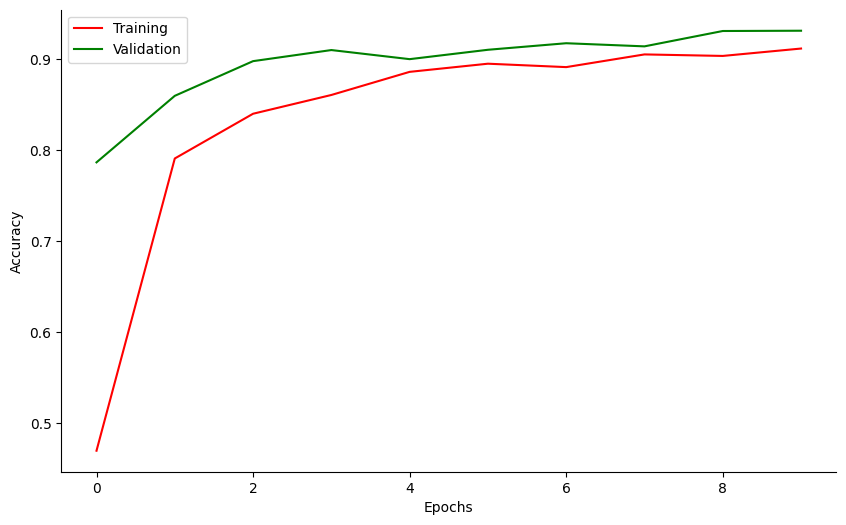

In [17]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="green",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
sns.despine()
plt.legend()
